In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.models as models
from torchvision.models import EfficientNet_B1_Weights
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
import seaborn as sns
from PIL import Image
from sklearn.metrics import classification_report

In [2]:
train_path = '/kaggle/input/casting-512-512/Casting_512_512/train'
test_path = '/kaggle/input/casting-512-512/Casting_512_512/test'

In [3]:
transformations = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(240),  # EfficientNet B1 uses 240x240 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
train_dataset = datasets.ImageFolder(root=train_path, transform=transformations)
test_dataset = datasets.ImageFolder(root=test_path, transform=transformations)

In [5]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [6]:
weights = EfficientNet_B1_Weights.IMAGENET1K_V1
model = models.efficientnet_b1(weights=weights)

In [7]:
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(train_dataset.classes))

In [8]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adamax(model.parameters(), lr=0.002)
# optimizer = optim.RMSprop(model.parameters(), lr=0.001)
# optimizer = optim.Adadelta(model.parameters(), lr=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.1)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



train_loss_history = []
train_accuracy_history = []

num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total * 100
    
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

Epoch 1/40, Train Loss: 6.1181, Train Accuracy: 52.94%
Epoch 2/40, Train Loss: 1.6720, Train Accuracy: 54.57%
Epoch 3/40, Train Loss: 0.8383, Train Accuracy: 62.56%
Epoch 4/40, Train Loss: 0.6811, Train Accuracy: 69.87%
Epoch 5/40, Train Loss: 0.5838, Train Accuracy: 77.77%
Epoch 6/40, Train Loss: 0.4791, Train Accuracy: 81.33%
Epoch 7/40, Train Loss: 0.3855, Train Accuracy: 82.19%
Epoch 8/40, Train Loss: 0.3929, Train Accuracy: 83.54%
Epoch 9/40, Train Loss: 0.3236, Train Accuracy: 86.72%
Epoch 10/40, Train Loss: 0.3825, Train Accuracy: 85.27%
Epoch 11/40, Train Loss: 0.3805, Train Accuracy: 84.89%
Epoch 12/40, Train Loss: 0.2692, Train Accuracy: 89.22%
Epoch 13/40, Train Loss: 0.2928, Train Accuracy: 88.74%
Epoch 14/40, Train Loss: 0.3124, Train Accuracy: 89.22%
Epoch 15/40, Train Loss: 0.4598, Train Accuracy: 84.31%
Epoch 16/40, Train Loss: 0.5166, Train Accuracy: 81.33%
Epoch 17/40, Train Loss: 0.3215, Train Accuracy: 87.49%
Epoch 18/40, Train Loss: 0.1997, Train Accuracy: 91.53%
E

In [10]:
val_loss_history = []
val_accuracy_history = []

for epoch in range(num_epochs):
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_inputs, val_labels in test_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            
            val_running_loss += val_loss.item()
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

        # Append the average validation loss for the epoch
        val_loss = val_running_loss / len(test_loader)
        val_loss_history.append(val_loss)

    val_accuracy = 100 * val_correct / val_total
    val_accuracy_history.append(val_accuracy)

print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Validation Loss: 0.3130, Validation Accuracy: 91.19%


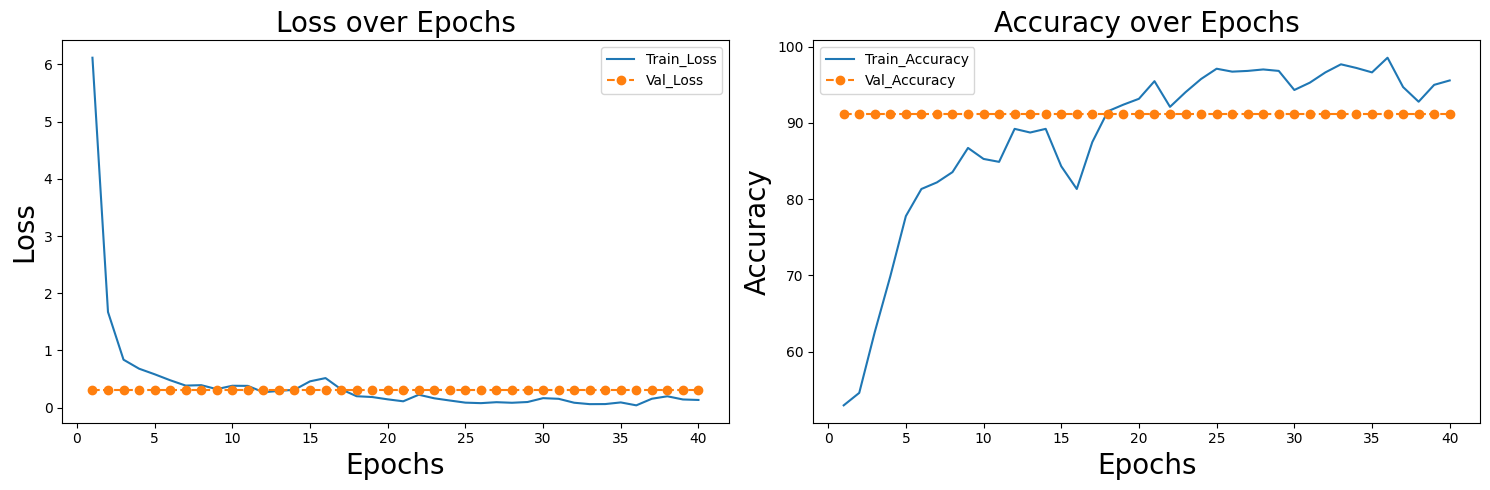

In [11]:
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train_Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Val_Loss', linestyle='--', marker='o')
plt.title('Loss over Epochs',fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label='Train_Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracy_history, label='Val_Accuracy', linestyle='--', marker='o')
plt.title('Accuracy over Epochs',fontsize=20)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.legend()

plt.tight_layout()
plt.savefig('Loss and Accuracy.png', dpi=300)
plt.show()

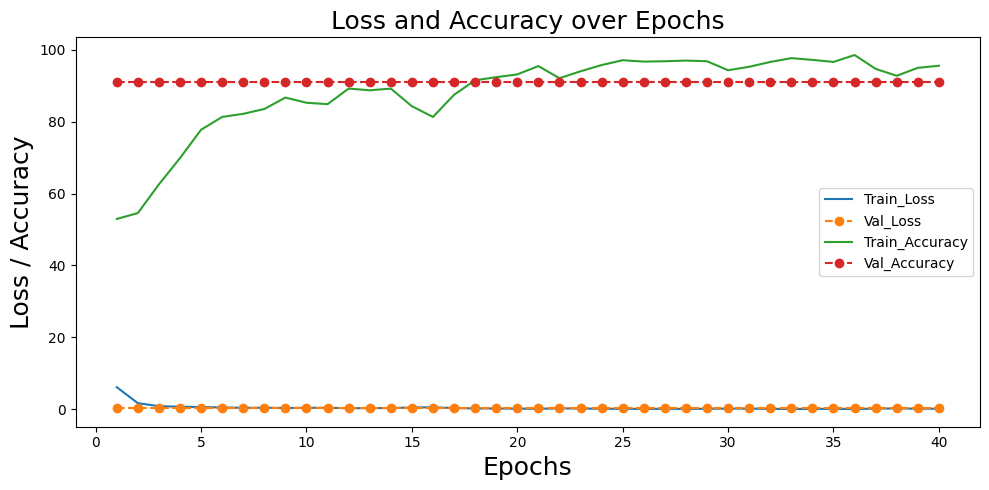

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Loss plot
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train_Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Val_Loss', linestyle='--', marker='o')

# Accuracy plot
plt.plot(range(1, num_epochs + 1), [acc for acc in train_accuracy_history], label='Train_Accuracy')
plt.plot(range(1, num_epochs + 1), [acc for acc in val_accuracy_history], label='Val_Accuracy', linestyle='--', marker='o')

plt.title('Loss and Accuracy over Epochs',fontsize=18)
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Loss / Accuracy',fontsize=18)
plt.legend()

plt.tight_layout()
plt.savefig('Loss and AccuracySingle.png', dpi=300)
plt.show()

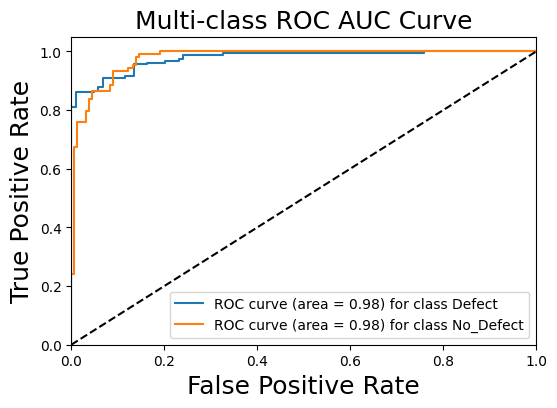

In [13]:
def plot_roc_curve(fpr, tpr, roc_auc, classes):
    plt.figure(figsize=(6, 4))
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {classes[i]}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Multi-class ROC AUC Curve',fontsize=18)
    plt.legend(loc="lower right")
    plt.savefig('ROC_AUC.png', dpi=300)
    plt.show()

model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        y_pred.extend(outputs.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(train_dataset.classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plot_roc_curve(fpr, tpr, roc_auc, train_dataset.classes)

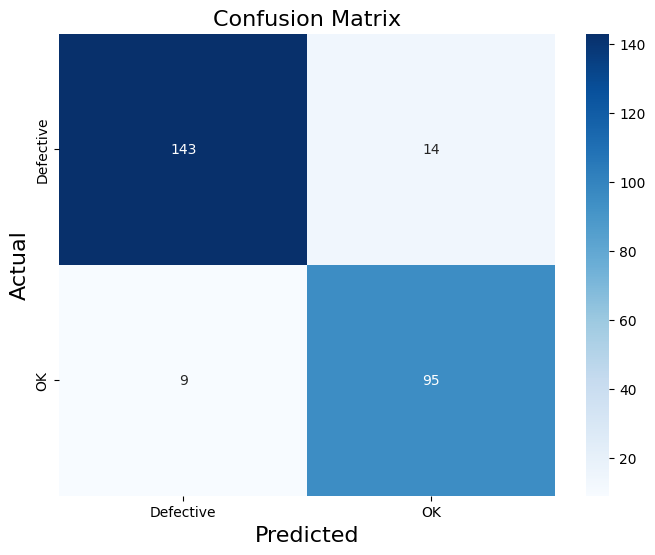

In [14]:
class_predictions = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, class_predictions)
labels = ['Defective', 'OK']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix',fontsize=16)
plt.ylabel('Actual',fontsize=16)
plt.xlabel('Predicted',fontsize=16 )
plt.savefig('ConfusionMatrix.png', dpi=300)
plt.show()

In [15]:
print(classification_report(y_true, class_predictions, target_names=train_dataset.classes))

              precision    recall  f1-score   support

      Defect       0.94      0.91      0.93       157
   No_Defect       0.87      0.91      0.89       104

    accuracy                           0.91       261
   macro avg       0.91      0.91      0.91       261
weighted avg       0.91      0.91      0.91       261



In [16]:
torch.save(model.state_dict(), 'EfficientNet.pth')